# Model implementation

Information Geometry Soft Clustering for Sport Analytics

Joaquin Garay

In [23]:
%load_ext autoreload
%autoreload 2

import os
import time
import tqdm
import numpy as np
import pandas as pd

import vis
import softclustering as sc

from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
import socceraction.spadl as spadl


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data Preparation

Concatenate actions of all games in one DataFrame.

In [24]:
datafolder = "data"
fifa2018h5 = os.path.join(datafolder, "spadl-fifa2018.h5")
games = pd.read_hdf(fifa2018h5, key="games")
with pd.HDFStore(fifa2018h5) as store:
    actions = []  #list of DataFrames
    for game in tqdm.tqdm(games.itertuples()):
        game_action = store[f"actions/game_{game.game_id}"]
        game_action = spadl.play_left_to_right(game_action, game.home_team_id)
        game_action["is_home"] = game_action["team_id"] == game.home_team_id
        actions.append(game_action)
    actions = pd.concat(actions)
    actions.drop("original_event_id", axis=1, inplace=True)
    actions = pd.merge(actions, spadl.config.actiontypes_df(), how="left")

64it [00:00, 170.00it/s]


In [25]:
def consolidate(actions):
    #actions.fillna(0, inplace=True)

    #Consolidate corner_short and corner_crossed
    corner_idx = actions.type_name.str.contains("corner")
    actions["type_name"] = actions["type_name"].mask(corner_idx, "corner")

    #Consolidate freekick_short, freekick_crossed, and shot_freekick
    freekick_idx = actions.type_name.str.contains("freekick")
    actions["type_name"] = actions["type_name"].mask(freekick_idx, "freekick")

    #Consolidate keeper_claim, keeper_punch, keeper_save, keeper_pick_up
    keeper_idx = actions.type_name.str.contains("keeper")
    actions["type_name"] = actions["type_name"].mask(keeper_idx, "keeper_action")

    actions["start_x"] = actions["start_x"].mask(actions.type_name == "shot_penalty", 94.5)
    actions["start_y"] = actions["start_y"].mask(actions.type_name == "shot_penalty", 34)

    return actions


actions = consolidate(actions)

In [26]:
#Actions of Team France matches.
len(actions[actions["team_id"] == 771])

6829

In [27]:
actions.groupby("type_name").size()

type_name
bad_touch         1547
clearance         2074
corner             558
cross             1305
dribble          52731
foul              1876
freekick          1272
goalkick           677
interception      1681
keeper_action      584
pass             56438
shot              1556
shot_penalty        68
tackle            1830
take_on           2109
throw_in          2178
dtype: int64

As suggested in SoccerMix, add noise on the starting and ending locations, but only on those actions that we can visually note a predefined pattern.
* *Add noise in both start and end locations*:
    * Cross
    * Shot
    * Keeper_action
    * Dribble
* *Only on start locations*:
    * Clearance
    * Goal kick
* *Only on end locations*:
    * Corner
    * Freekick
    * Shot_penalty

In [28]:
def add_noise(actions):
    # Start locations
    start_list = ["cross", "shot", "keeper_action", "clearance", "goalkick", "dribble"]
    mask = actions["type_name"].isin(start_list)
    noise = np.random.normal(0, 0.5, size=actions.loc[mask, ["start_x", "start_y"]].shape)
    actions.loc[mask, ["start_x", "start_y"]] += noise

    # End locations
    end_list = ["cross", "shot", "keeper_action", "corner", "freekick", "shot_penalty", "dribble"]
    mask = actions["type_name"].isin(end_list)
    noise = np.random.normal(0, 0.5, size=actions.loc[mask, ["end_x", "end_y"]].shape)
    actions.loc[mask, ["end_x", "end_y"]] += noise

    return actions


actions = add_noise(actions)

In [29]:
# # display event locations with noise
# corrected_actions = ["cross", "shot", "keeper_action", "clearance", "goalkick","corner", "freekick", "shot_penalty"]
# for actiontype in corrected_actions:
#     actions[actions.type_name == actiontype].plot.scatter(
#         x="start_x",
#         y="start_y",
#         title = f"Start Location: {actiontype}",
#         figsize = (6,4)
#     )
#     plt.show()
#     actions[actions.type_name == actiontype].plot.scatter(
#         x="end_x",
#         y="end_y",
#         title = f"End Location: {actiontype}",
#         figsize = (6,4)
#     )
#     plt.show()

In [30]:
def remove_outliers(actions, verbose=False):
    X = actions[["start_x","start_y","end_x","end_y"]].to_numpy(dtype=float)
    inliers = LocalOutlierFactor(contamination="auto").fit_predict(X)
    if verbose:
        print(f"Remove {(inliers==-1).sum()} out of {X.shape[0]} datapoints.")
    return actions[inliers==1]

actions = remove_outliers(actions,True)

Remove 567 out of 128484 datapoints.


### Features

Compute the angle of the direction of the action with respect with the x-axis (pitch's length) a
$$\tan \theta = \frac{y_{end} - y_{start}}{x_{end} - x_{start}}$$

In [31]:
actions["angle"] = np.arctan2(actions.end_y - actions.start_y, actions.end_x - actions.start_x)
actions["cos_angle"] = np.cos(actions["angle"])
actions["sin_angle"] = np.sin(actions["angle"])
actions[["angle", "cos_angle", "sin_angle"]].describe()

,angle,cos_angle,sin_angle
count,127917.000000,127917.000000,127917.000000
mean,0.007327,0.278564,-0.005591
std,1.499046,0.680231,0.677985
min,-3.141572,-1.000000,-1.000000
25%,-1.081524,-0.268142,-0.665026
50%,0.000000,0.471934,0.000000
75%,1.077660,0.926947,0.647380
max,3.141593,1.000000,1.000000


### First run

Let's run a first toy implementation using throw-ins of team France.

In [32]:
mask = (actions["type_name"]=="dribble") & (actions["team_id"]==771)
loc_data = actions[mask][["start_x", "start_y"]]
dir_data = actions[mask][["cos_angle", "sin_angle"]]

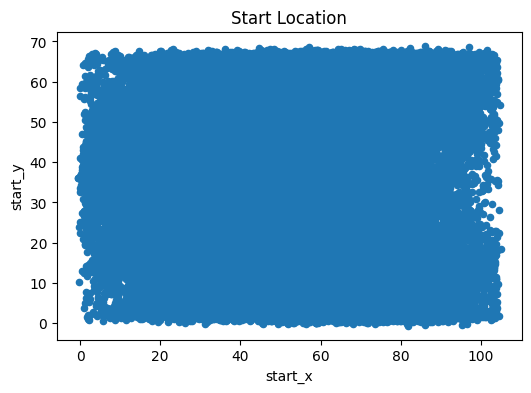

In [33]:
loc_data.plot.scatter(
        x="start_x",
        y="start_y",
        title = f"Start Location",
        figsize = (6,4)
    )
plt.show()

In [34]:
#Gaussian clusters
k_gauss = 7

gauss_clusters = [sc.MultivariateGaussian() for j in range(k_gauss)]

loc_em_model = sc.MixtureModel(gauss_clusters)
loc_bregman_model = sc.MixtureModel(gauss_clusters)

# Classic EM
start = time.time()
res_em = loc_em_model.fit_em_classic(loc_data, verbose=False)
t_em = time.time() - start

# Bregman EM
start = time.time()
res_bregman = loc_bregman_model.fit_em_bregman(loc_data, verbose=False)
t_bregman = time.time() - start

# Results
print(f"Final log-likelihoods:\nEM: {res_em[-1]:.4f}\nBregman: {res_bregman[-1]:.4f}")
print(f"Timings:\nEM: {t_em:.4f}s\nBregman: {t_bregman:.4f}s")

Final log-likelihoods:
EM: -457563.9556
Bregman: -457563.9556
Timings:
EM: 8.4205s
Bregman: 6.5831s


In [35]:
#for model in [loc_em_model, loc_bregman_model]:
#    print(f"{model}\n")

In [36]:
#Von Mises Clusters
k_vm = 3

vm_clusters = [sc.VonMises() for _ in range(k_vm)]

dir_em_model = sc.MixtureModel(vm_clusters)
dir_proxy_model = sc.MixtureModel(vm_clusters)
dir_bregman_model = sc.MixtureModel(vm_clusters)

# Classic EM
start = time.time()
res_em = dir_em_model.fit_em_classic(dir_data, verbose=False)
t_em = time.time() - start

# Proxy EM for Von Mises
start = time.time()
res_proxy = dir_proxy_model.fit_em_vonmises_approx(dir_data, verbose=False)
t_proxy = time.time() - start

# Bregman EM
start = time.time()
res_bregman = dir_bregman_model.fit_em_bregman(dir_data, verbose=False)
t_bregman = time.time() - start

# Results
print(f"Final log-likelihoods:\nEM: {res_em[-1]:.4f}\nProxy: {res_proxy[-1]:.4f}\nBregman: {res_bregman[-1]:.4f}")
print(f"Timings:\nEM: {t_em:.4f}s\nProxy: {t_proxy:.4f}s\nBregman: {t_bregman:.4f}s")


Final log-likelihoods:
EM: -94034.2052
Proxy: -93962.9924
Bregman: -94043.4670
Timings:
EM: 3.4861s
Proxy: 2.0402s
Bregman: 2.0273s


In [37]:
for model in [dir_em_model, dir_bregman_model, dir_proxy_model]:
    print(f"{model}\n")

MixtureModel(n_clusters=3)
  ├─ (0) w=0.461  VonMises(loc=-10.2º, kappa=0.973)
  ├─ (1) w=0.288  VonMises(loc=60.0º, kappa=0.464)
  └─ (2) w=0.250  VonMises(loc=-131.0º, kappa=0.515)

MixtureModel(n_clusters=3)
  ├─ (0) w=0.500  VonMises(loc=-10.2º, kappa=0.973)
  ├─ (1) w=0.284  VonMises(loc=60.0º, kappa=0.464)
  └─ (2) w=0.216  VonMises(loc=-131.0º, kappa=0.515)

MixtureModel(n_clusters=3)
  ├─ (0) w=0.079  VonMises(loc=-10.2º, kappa=0.973)
  ├─ (1) w=0.165  VonMises(loc=60.0º, kappa=0.464)
  └─ (2) w=0.756  VonMises(loc=-131.0º, kappa=0.515)



Running Time bregman Model: 19.8771s



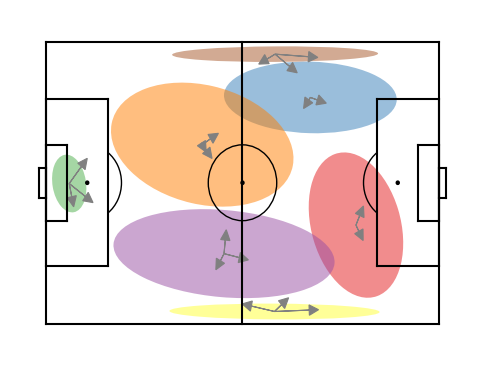

In [38]:
K_loc = 7
K_dir = 3
results = {}

choose = "bregman"
start = time.time()
results[choose] = sc.two_layer_scheme(loc_data, dir_data, K_loc, K_dir, choose=choose)
run_time = time.time() - start

print(f"Running Time {choose} Model: {run_time:.4f}s\n")
# print(f"{results[choose][0]}\n")
# for i, vmm in enumerate(results[choose][1]):
#     print(f"GMM Cluster {i}: ")
#     print(f"{vmm}\n")

gmm, vmm = results["bregman"]
vis.show_all_models(gmm, vmm)

Running Time soccermix Model: 17.7959s



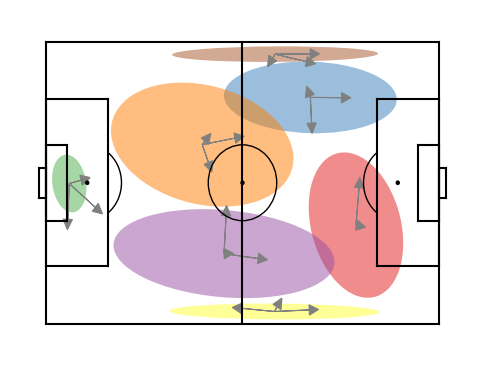

In [39]:
choose = "soccermix"
start = time.time()
results[choose] = sc.two_layer_scheme(loc_data, dir_data, K_loc, K_dir, choose=choose)
run_time = time.time() - start

print(f"Running Time {choose} Model: {run_time:.4f}s\n")
# print(f"{results[choose][0]}\n")
# for i, vmm in enumerate(results[choose][1]):
#     print(f"GMM Cluster {i}: ")
#     print(f"{vmm}\n")

gmm, vmm = results[choose]
vis.show_all_models(gmm, vmm)

Running Time classic Model: 33.7364s



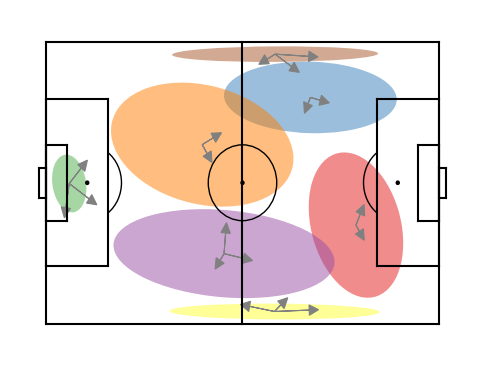

In [40]:
choose = "classic"
start = time.time()
results[choose] = sc.two_layer_scheme(loc_data, dir_data, K_loc, K_dir, choose=choose)
run_time = time.time() - start

print(f"Running Time {choose} Model: {run_time:.4f}s\n")
# print(f"{results[choose][0]}\n")
# for i, vmm in enumerate(results[choose][1]):
#     print(f"GMM Cluster {i}: ")
#     print(f"{vmm}\n")

gmm, vmm = results[choose]
vis.show_all_models(gmm, vmm)

In [50]:
gauss_1 = gmm.get_components()[0]
gauss_2 = gmm.get_components()[4]

print(gauss_1)
print(gauss_2)

mean_1, cov_1 = gauss_1.get_params()
mean_2, cov_2 = gauss_2.get_params()
gauss_1.divergence(mean_1, cov_1, mean_2, cov_2)

MultivariateGaussian(d=2, mean=[70.638 54.589], cov=[[266.572  -5.792], [-5.792 37.381]])
MultivariateGaussian(d=2, mean=[41.735 43.198], cov=[[297.48  -40.724], [-40.724 111.912]])


3.964388893196123

In [20]:
# Collect BIC and AIC results
rows = []
for key, value in results.items():
    loc_model = value[0]
    dir_models = value[1]

    loc_bic = round(loc_model.bic(loc_data),0)
    loc_aic = round(loc_model.aic(loc_data),0)
    rows.append({"Model": key, "Component": "loc_model", "BIC": loc_bic, "AIC": loc_aic})

    for i, dir_model in enumerate(dir_models):
        dir_bic = round(dir_model.bic(dir_data),0)
        dir_aic = round(dir_model.aic(dir_data),0)
        rows.append({"Model": key, "Component": f"dir_model_{i}", "BIC": dir_bic, "AIC": dir_aic})

# Create DataFrame
scores_df = pd.DataFrame(rows)
scores_df.groupby("Model").sum()


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)